In [1]:
import keras.losses
import numpy as np
import pandas as pd
from pydicom import dcmread
import pydicom.pixel_data_handlers
import nibabel as nib
import os
import tensorflow as tf
from keras.layers import CategoryEncoding, IntegerLookup
import matplotlib.pyplot as plt
import re

CURRENT_DIR_PATH = os.getcwd()

TRAIN_IMAGE_PATH = os.path.join(CURRENT_DIR_PATH, "train_images")
SEGMENTATIONS_PATH = os.path.join(CURRENT_DIR_PATH, "segmentations")
TRAIN_CSV_PATH = os.path.join(CURRENT_DIR_PATH, "train.csv")

AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 75

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

def pad_list(labels_to_pad):
    return [labels_to_pad[len(labels_to_pad) - 1] if i >= len(labels_to_pad) else labels_to_pad[i] for i in range(0, 8)]

def labels_for_image(vertebrae):
    vertebrae_for_image = list(filter(lambda vertebra: vertebra > 0, vertebrae))
    labels_to_pad = list((map(lambda vertebra: int(vertebra), vertebrae_for_image))) if len(vertebrae_for_image) > 0 else [0]
    padded_labels = pad_list(labels_to_pad)
    return padded_labels

def preprocess_data():
    segmentation_patient_files = os.listdir(SEGMENTATIONS_PATH)
    train_images = []
    train_image_labels = []

    for segmentation_patient_file in segmentation_patient_files:
        file_path = os.path.join(SEGMENTATIONS_PATH, segmentation_patient_file)
        segmentation_file = nib.load(file_path).get_fdata()
        segmentation_file_transposed = segmentation_file[:, ::-1, ::-1].transpose(2, 1, 0)

        for slice_number in range(0, len(segmentation_file_transposed)):
            dicom_slice = segmentation_file_transposed[slice_number]
            vertebrae = np.unique(dicom_slice)
            labels = labels_for_image(vertebrae)
            train_image_labels.append(labels)
            train_images_path = os.path.join(TRAIN_IMAGE_PATH, file_path.split("/")[-1].replace('.nii', ""))
            image_dir = os.listdir(train_images_path)
            image_dir.sort(key=natural_keys)
            image_path = os.path.join(train_images_path, image_dir[slice_number])
            # decoded_image = decode_img(image_path)
            train_images.append(image_path)

     # categories = create_categories(train_image_labels)
    dataset_size = len(train_images)
    val_size = int(dataset_size * 0.2)
    x_t = train_images[val_size:]
    y_t = train_image_labels[val_size:]

    x_v = train_images[:val_size]
    y_v = train_image_labels[:val_size]

    return x_t, y_t, x_v, y_v

x_train, y_train, x_val, y_val = preprocess_data()

2022-09-29 19:22:13.134870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 19:22:13.134915: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
def create_categories(labels_for_categories):
    vocab = [1, 2, 3, 4, 5, 6, 7]
    index = IntegerLookup(vocabulary=vocab)
    encoder = CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode='multi_hot')
    categories = encoder(index(labels_for_categories))

    return tf.reshape(categories, [8])

def decode_img(path):
    with open(path, 'rb') as image_file:
        ds = dcmread(image_file)
        img = ds.pixel_array
        img = img / 255
        img = tf.reshape(img, [512, 512, 1])

        return img

def combine_image_and_labels(filename, labels):
    labels = create_categories(labels)
    image = decode_img(filename)

    return image, labels

def create_dataset(filepaths, labels, is_training=True):
    # test_return = combine_image_and_labels(train_images[0], train_image_labels[0])
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda path, label: tf.py_function(func=combine_image_and_labels, inp=[path, label], Tout=(tf.float64, tf.float32)), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    dataset.map(combine_image_and_labels, num_parallel_calls=AUTOTUNE)
    # train_dataset = tf.data.Dataset.from_tensor_slices((np.array(x_train), y_train))

    if is_training:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=len(filepaths))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

train_ds = create_dataset(x_train, y_train)
train_dataset = train_ds
val_ds = create_dataset(x_val, y_val)
val_dataset = val_ds

for f, l in train_dataset.take(1):
    print(f.shape)
    print(l.shape)

In [9]:
d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
  return t.decode('utf-8').upper()
# d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
#           inp=[x], Tout=tf.string))
d = d.map(lambda x: upper_case_fn(x))
list(d.as_numpy_iterator())



# dataset = tf.data.Dataset.range(3)
#
# def g(x):
#   return tf.constant(37.0), tf.constant(["Foo", "Bar", "Baz"])
# result = dataset.map(g)
# result.element_spec


AttributeError: in user code:

    File "/tmp/ipykernel_16175/2092610460.py", line 6, in None  *
        lambda x: upper_case_fn(x)
    File "/tmp/ipykernel_16175/2119460770.py", line 3, in upper_case_fn  *
        return t.decode('utf-8').upper()

    AttributeError: 'Tensor' object has no attribute 'decode'


In [3]:
from keras import Sequential
import keras.layers as layers
from tensorflow import keras

def create_model():
    seq_model = Sequential([
        layers.Conv2D(64, 7, padding='same', activation='relu', input_shape=(512, 512, 1)),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(8, activation='softmax')
    ])

    return seq_model

model = create_model()
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()
# optimizer = keras.optimizers.SGD(learning_rate=0.001)
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 64)      3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 256)     2

In [4]:
import time

epochs = 2

model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)
# for epoch in range(epochs):
#     print("\nStart of epoch %d" % (epoch,))
#     start_time = time.time()
#
#     for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
#         with tf.GradientTape() as tape:
#             logits = model(x_batch_train, training=True)
#             loss_value = loss_fn(y_batch_train, logits)
#
#         grads = tape.gradient(loss_value, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights))
#
#         if step % 200 == 0:
#             print(
#                 "Training loss (for one batch) at step %d: %.4f"
#                 % (step, float(loss_value))
#             )
#             print("Seen so far: %s samples" % ((step + 1) * batch_size))





Epoch 1/2


ValueError: in user code:

    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/training.py", line 894, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/training.py", line 987, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 480, in update_state
        self.build(y_pred, y_true)
    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 393, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 526, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 526, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/cbarb15/PycharmProjects/venv/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 547, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    ValueError: as_list() is not defined on an unknown TensorShape.


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

# l = loss(model, features, labels, training=False)
# print("Loss test: {}".format(l))

In [ ]:
import random

#  Loss function for training on breaks

def get_weight(key, value):
    is_vertebrae = re.match(r'^C[1-9]$', key)
    if is_vertebrae and value == 0:
        return 1
    elif is_vertebrae and value == 1:
        return 2
    elif key == 'patient_overall' and value == 0:
        return 7
    elif key == 'patient_overall' and value == 1:
        return 14

def loss(patient_id):
    df = pd.read_csv(TRAIN_CSV_PATH)
    patient_row = df.loc[df['StudyInstanceUID'] == patient_id]
    total_loss = 0
    for i in range(1, patient_row.shape[1]):
        key = patient_row.iloc[:, i].name
        y_ij = patient_row.iloc[:, i].values[0]
        w_j = get_weight(key, y_ij)
        p_ij = random.uniform(0, 1)
        total_loss += w_j * (y_ij * np.log(p_ij) + (1 - y_ij) * np.log(1 - p_ij))

    return total_loss

loss('1.2.826.0.1.3680043.780')

In [ ]:
# import tensorflow as tf
# from keras.layers import CategoryEncoding, IntegerLookup

# vocab = [1, 2, 3, 4, 5, 6, 7]
# vertebrae = tf.constant([[0, 0], [1, 1], [1, 2], [5, 6], [8, 9], [2, 3]])
# index = IntegerLookup(vocabulary=vocab)
# encoder = CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode='multi_hot')
# categories = encoder(index(vertebrae))
# print(categories)

In [ ]:
label_array = [[0], [1], [1, 2], [8, 9], [1, 2, 3]]
# convert to list of 7 taking the first number adding it as padding to fill missing numbers
labels_padded = []
# for labels in label_array:
#     labels_padded = []
#     new_list = [labels[len(labels) - 1] if i >= len(labels) or labels[i] > 8 else labels[i] for i in range(0, 8)]
    # for i in range(0, 8):
    #     if i >= len(labels):
    #         labels_padded.append(labels[len(labels) - 1])
    #     else:
    #         labels_padded.append(labels[i])


# with open(os.path.join(train_images_path, image_dir[0]), 'rb') as file:
#     ds = dcmread(file)
#     print(ds.pixel_array.shape)



# with open(image_path, 'rb') as file:
#     ds = dcmread(file)
#     image_tensor = tf.convert_to_tensor(ds.pixel_array)

# def decode_img(img):
#   # Convert the compressed string to a 3D uint8 tensor
#   img = tf.io.decode_jpeg(img, channels=3)
#   # Resize the image to the desired size
#   return tf.image.resize(img, [180, 180])
#
# def process_path(file_path):
#   # Load the raw data from the file as a string
#   img = tf.io.read_file(file_path)
#   img = decode_img(img)
#   return img
#
# image_path = "/home/cbarb15/PycharmProjects/RSNACervicalSpineFractureDetection/train_images/1.2.826.0.1.3680043.780/1.dcm"
#
# with open(image_path, 'rb') as file:
#     ds = dcmread(file)
#     image_tensor = tf.convert_to_tensor(ds.pixel_array)
#     process_path()

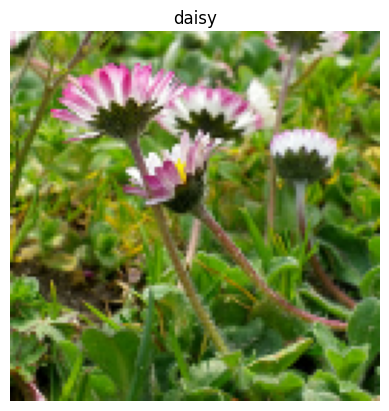

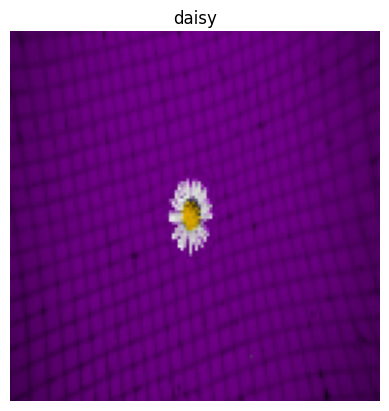

In [24]:
path = os.path.join(CURRENT_DIR_PATH, "flower_photos/daisy")
list_ds = tf.data.Dataset.list_files(str(f'{path}/*.jpg'))

def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

# file_path = next(iter(list_ds))
# image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')


images_ds = list_ds.map(parse_image)
for image, label in images_ds.take(2):
    show(image, label)